# mean velocity of currents and wind

In [68]:
import xarray as xr
import numpy as np
import pandas as pd
import glob
from os.path import join
import dask
import matplotlib.pyplot as plt
import cmocean

In [220]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(fig, ax, var, fmt=None, range_limit=None):
    """Colorbar position and format properly"""
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)    
    cb = fig.colorbar(var, cax=cax, format=fmt)
    if range_limit:
        cb.mappable.set_clim(range_limit)    
    cb.ax.tick_params(which='major', labelsize=6, length=3, width=0.5, pad=0.05)
    return cb

import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
def geo_map(ax):
    # ticks
    ax.set_xticks(np.arange(-95, -45, 10), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(5, 32, 5), crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)
    ax.set_extent([-98, -52, 4, 31], crs=ccrs.PlateCarree())

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:35399")
client

<Client: 'tcp://127.0.0.1:35399' processes=12 threads=96, memory=502.56 GiB>

In [5]:
#!ls /nexsan/people/pmiron/GLBv0.08_caribbean/2010

In [7]:
base_folder = '/nexsan/people/pmiron/GLBv0.08_caribbean'
filenames = []
for year in range(2010, 2011):#2022):
    for type in ['c']:
        for h in range(0,24,3): # avoid reading filenames with hours > 21
            filenames.extend(glob.glob(join(base_folder, f'{year}', f'hycom_GLBv0.08*t0{h:02d}.nc')))
        filenames = sorted(filenames)

In [20]:
ds = xr.open_mfdataset(filenames, data_vars="minimal", decode_cf=False)
ds = xr.decode_cf(ds)

In [22]:
ds

<xarray.Dataset>
Dimensions:    (time: 2887, lat: 394, lon: 603)
Coordinates:
  * time       (time) datetime64[ns] 2010-01-01 ... 2010-12-31T21:00:00
Dimensions without coordinates: lat, lon
Data variables:
    latitude   (lat) float32 dask.array<chunksize=(394,), meta=np.ndarray>
    longitude  (lon) float32 dask.array<chunksize=(603,), meta=np.ndarray>
    surf_u     (time, lat, lon) float32 dask.array<chunksize=(1, 394, 603), meta=np.ndarray>
    surf_v     (time, lat, lon) float32 dask.array<chunksize=(1, 394, 603), meta=np.ndarray>

In [23]:
month_length = ds.time.dt.days_in_month

In [24]:
# Calculate the weights by grouping by 'time.season'.
weights = (
    month_length.groupby("time.season") / month_length.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted = (ds * weights).groupby("time.season").sum(dim="time")

# reorder the season
ds_weighted = ds_weighted.reindex({'season': ['DJF','MAM','JJA', 'SON']})

In [46]:
base_folder = '/nexsan/people/pmiron/GLBv0.08_caribbean'
filenames_w = []
for year in range(2010, 2011):#2022):
    for type in ['c']:
        for h in range(0,24,3): # avoid reading filenames with hours > 21
            filenames_w.extend(glob.glob(join(base_folder, f'{year}w', f'JRA55_GLBv0.08*t0{h:02d}.nc')))
        filenames_w = sorted(filenames_w)

In [48]:
ds_w = xr.open_mfdataset(filenames_w, data_vars="minimal", decode_cf=False)
ds_w = xr.decode_cf(ds_w)

In [56]:
# Calculate the weights by grouping by 'time.season'.
weights_w = (
    month_length_w.groupby("time.season") / month_length_w.groupby("time.season").sum()
)

# Test that the sum of the weights for each season is 1.0
np.testing.assert_allclose(weights_w.groupby("time.season").sum().values, np.ones(4))

# Calculate the weighted average
ds_weighted_w = (ds_w * weights_w).groupby("time.season").sum(dim="time")

# reorder the season
ds_weighted_w = ds_weighted_w.reindex({'season': ['DJF','MAM','JJA', 'SON']})

In [ ]:
ds_weighted.to_netcdf('seasonal_c.nc')
ds_weighted_w.to_netcdf('seasonal_w.nc')

In [ ]:
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6

In [ ]:
lon = ds.longitude.compute()
lat = ds.latitude.compute()
lonw = ds_w.longitude.compute()
latw = ds_w.latitude.compute()

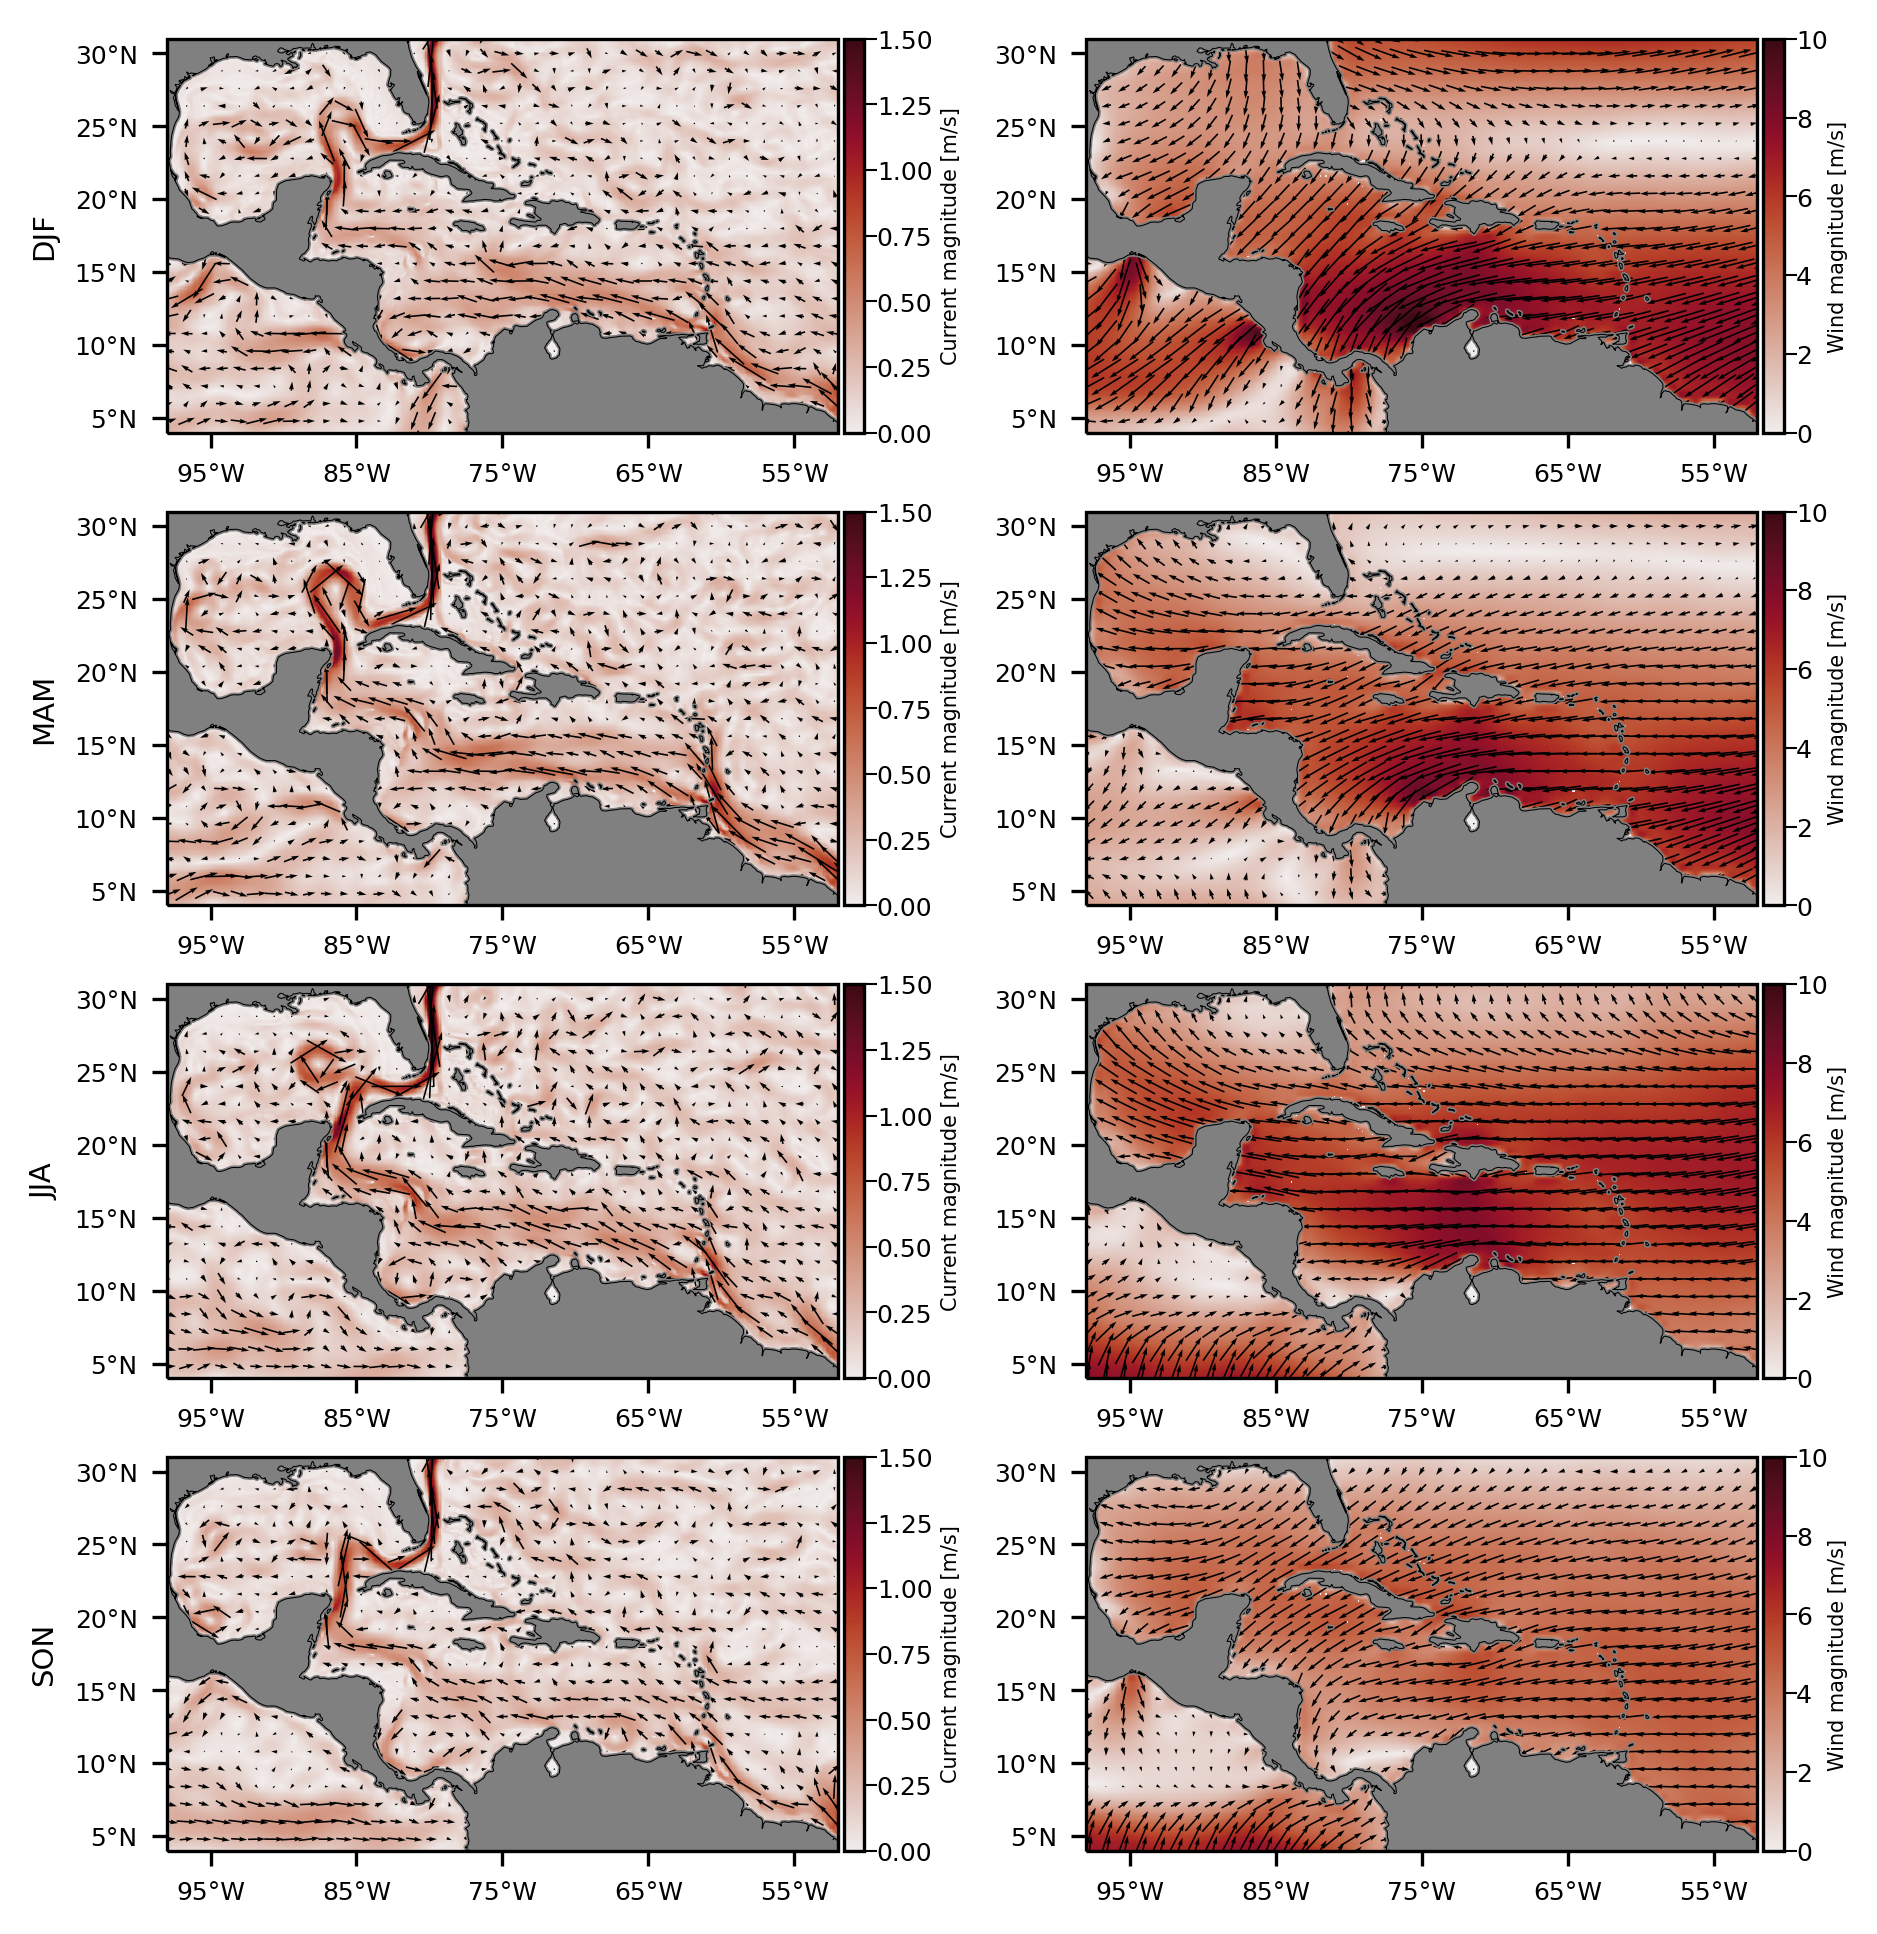

In [287]:
fig = plt.figure(dpi=300,figsize=(7.25,8))
axes = fig.subplots(4,2,subplot_kw=dict(projection=ccrs.PlateCarree()))

skip = 15

seasons = ['DJF', 'MAM', 'JJA', 'SON']

for i in range(0,4):
    uc = ds_weighted.surf_u[i].compute()
    vc = ds_weighted.surf_v[i].compute()
    uw = ds_weighted_w.uwnd[i].compute()
    vw = ds_weighted_w.vwnd[i].compute()

    axes[i,0].set_ylabel(seasons[i],fontsize=7)
    pc = axes[i,0].pcolormesh(lon,lat,np.sqrt(uc**2+vc**2), cmap=cmocean.cm.amp, vmax=1.5)
    axes[i,0].quiver(lon[::skip],lat[::skip],
                     uc[::skip,::skip],vc[::skip,::skip], 
                     scale=5, scale_units='inches', 
                     pivot='mid')
    cb = add_colorbar(fig, axes[i,0], pc)
    cb.set_label('Current magnitude [m/s]', fontsize=5, labelpad=2)
    
    pc = axes[i,1].pcolormesh(lonw,latw,np.sqrt(uw**2+vw**2), cmap=cmocean.cm.amp, vmax=10)
    axes[i,1].quiver(lonw[::skip],latw[::skip],
                     uw[::skip,::skip],vw[::skip,::skip], 
                     scale=50, scale_units='inches', 
                     pivot='mid')
    cb = add_colorbar(fig, axes[i,1], pc)
    cb.set_label('Wind magnitude [m/s]', fontsize=5, labelpad=0)

for ax in axes.flatten():
    geo_map(ax)
    
fig.savefig('seasonality_wf.png', format='png', dpi=600)